# Analyse exploratoire 

Aperçu des données :
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...          

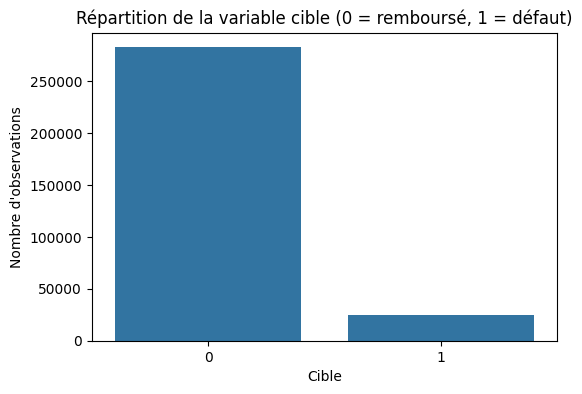

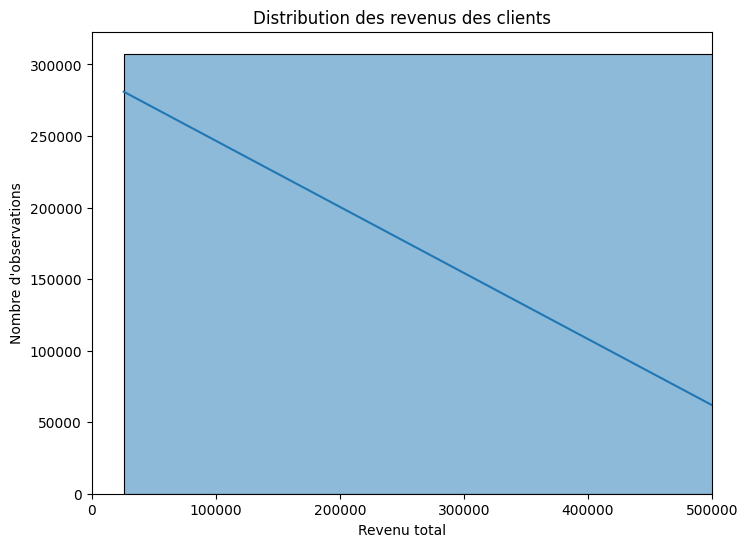

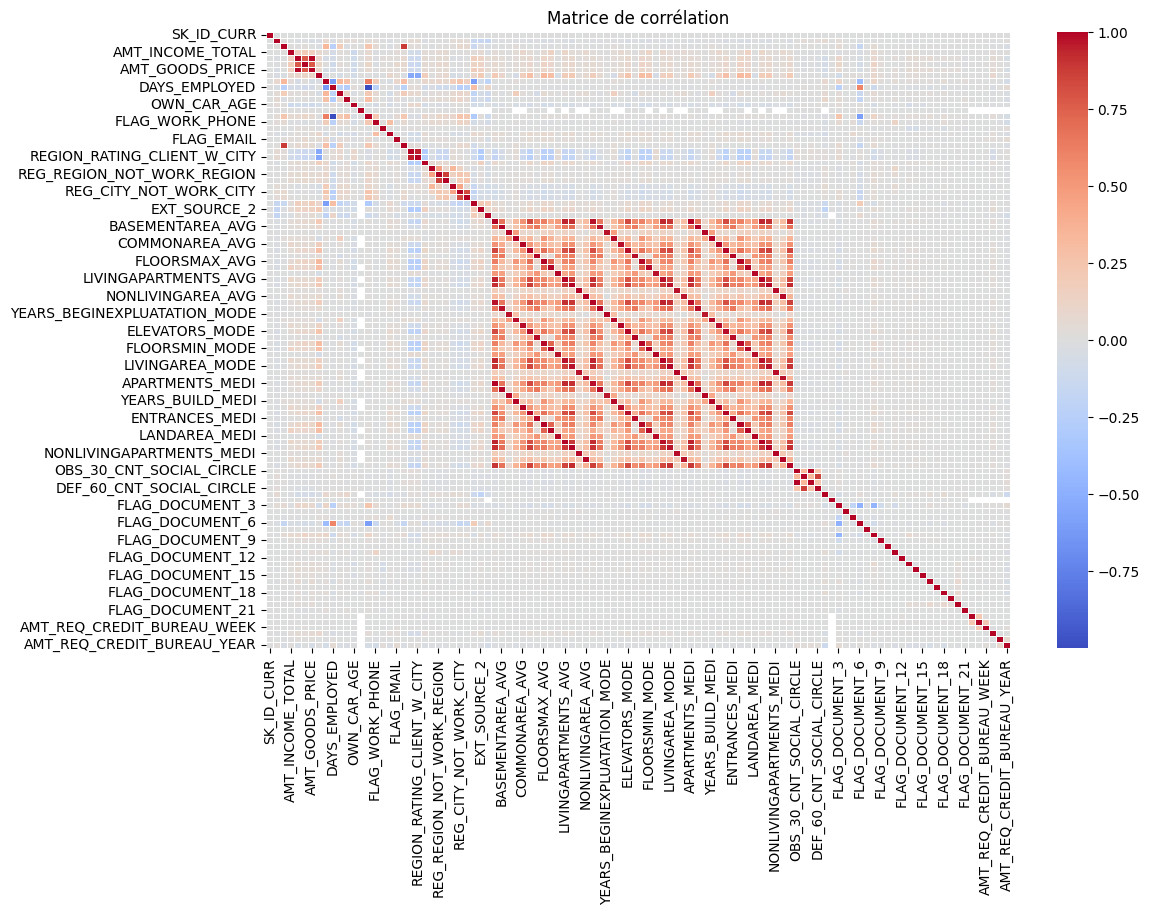


Top 10 des features les plus corrélées avec TARGET :
TARGET                         1.000000
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
Name: TARGET, dtype: float64

Nombre de variables numériques : 106
Nombre de variables catégoriques : 16

Valeurs uniques de NAME_CONTRACT_TYPE:
NAME_CONTRACT_TYPE
Cash loans         278232
Revolving loans     29279
Name: count, dtype: int64

Valeurs uniques de CODE_GENDER:
CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64

Valeurs uniques de FLAG_OWN_CAR:
FLAG_OWN_CAR
N    202924
Y    104587
Name: count, dtype: int64

Valeurs uniques de FLAG_OWN_REALTY:
FLAG_OWN_REALTY
Y    213312
N     94199
Name: count, dtyp

In [1]:
# 📌 Importation des bibliothèques nécessaires
import numpy as np
import pandas as pd
import re
import mlflow
import mlflow.sklearn
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


# Chargement des données
file_path = "application_train.csv"  # Remplacez par le chemin réel si nécessaire
df = pd.read_csv(file_path)

# Affichage des premières lignes
print("Aperçu des données :")
print(df.head())

# Dimensions du dataset
print("\nNombre de lignes et de colonnes :", df.shape)

# Types de données et valeurs manquantes
print("\nInformations sur les données :")
print(df.info())

# Pourcentage de valeurs manquantes par colonne
missing_values = df.isnull().sum()
missing_values_percent = (missing_values / len(df)) * 100
missing_values_table = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_values_percent})
missing_values_table = missing_values_table[missing_values_table['Missing Values'] > 0].sort_values(by='Percentage', ascending=False)

print("\nColonnes avec des valeurs manquantes :")
print(missing_values_table.head(20))  # Affiche les 20 colonnes les plus affectées

# Statistiques descriptives
print("\nStatistiques descriptives :")
print(df.describe())

# Distribution de la variable cible (TARGET)
plt.figure(figsize=(6, 4))
sns.countplot(x=df['TARGET'])
plt.title("Répartition de la variable cible (0 = remboursé, 1 = défaut)")
plt.xlabel("Cible")
plt.ylabel("Nombre d'observations")
plt.show()

# Distribution des revenus des clients
plt.figure(figsize=(8, 6))
sns.histplot(df['AMT_INCOME_TOTAL'], bins=50, kde=True)
plt.title("Distribution des revenus des clients")
plt.xlabel("Revenu total")
plt.ylabel("Nombre d'observations")
plt.xlim(0, 500000)  # Limitation pour éviter les valeurs extrêmes
plt.show()

# Sélection des colonnes numériques uniquement
numeric_df = df.select_dtypes(include=['number'])

# Matrice de corrélation
corr_matrix = numeric_df.corr()

# Affichage avec heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Matrice de corrélation")
plt.show()


# Corrélation avec la variable cible
correlation_target = corr_matrix["TARGET"].sort_values(ascending=False)
print("\nTop 10 des features les plus corrélées avec TARGET :")
print(correlation_target.head(10))

# Catégorisation des variables numériques et catégoriques
num_features = df.select_dtypes(include=['int64', 'float64']).columns
cat_features = df.select_dtypes(include=['object']).columns

print("\nNombre de variables numériques :", len(num_features))
print("Nombre de variables catégoriques :", len(cat_features))

# Analyse des valeurs uniques des variables catégoriques
for col in cat_features[:5]:  # Affichage des 5 premières variables catégoriques
    print(f"\nValeurs uniques de {col}:")
    print(df[col].value_counts())

# Transformation des variables catégoriques en indicatrices (one-hot encoding)
df_encoded = pd.get_dummies(df, drop_first=True)
print("\nDonnées transformées avec variables indicatrices (one-hot encoding) :")
print(df_encoded.shape)



# Preparation de données et features engenering pour train et test

In [2]:
import numpy as np
import pandas as pd
import pickle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import mlflow

# Chargement des fichiers train et test
train_path = "application_train.csv"
test_path = "application_test.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Sauvegarde des IDs du test pour la soumission
test_ids = df_test["SK_ID_CURR"]

# Concaténation des datasets pour un prétraitement uniforme
df = pd.concat([df_train, df_test], axis=0, ignore_index=True)

# Remplacement des valeurs anormales dans DAYS_EMPLOYED
df = df.copy()
df["DAYS_EMPLOYED"] = df["DAYS_EMPLOYED"].astype(np.float64)
df.loc[:, "DAYS_EMPLOYED"] = df["DAYS_EMPLOYED"].replace(365243, np.nan)

# Gestion des valeurs manquantes (pour les numériques)
imputer = SimpleImputer(strategy="median")
df[df.select_dtypes(include=['number']).columns] = imputer.fit_transform(df.select_dtypes(include=['number']))

# Gestion des valeurs manquantes (pour les catégoriques)
imputer_cat = SimpleImputer(strategy="most_frequent")
df[df.select_dtypes(include=['object']).columns] = imputer_cat.fit_transform(df.select_dtypes(include=['object']))

# Encodage des variables catégoriques
df = pd.get_dummies(df, drop_first=True)

# Création de nouvelles features
df["CREDIT_INCOME_RATIO"] = df["AMT_CREDIT"] / df["AMT_INCOME_TOTAL"]
df["ANNUITY_INCOME_RATIO"] = df["AMT_ANNUITY"] / df["AMT_INCOME_TOTAL"]
df["CREDIT_TERM"] = df["AMT_ANNUITY"] / df["AMT_CREDIT"]
df["INCOME_PER_PERSON"] = df["AMT_INCOME_TOTAL"] / df["CNT_FAM_MEMBERS"]
df["PAYMENT_RATE"] = df["AMT_ANNUITY"] / df["AMT_CREDIT"]

df["DAYS_EMPLOYED_RATIO"] = df["DAYS_EMPLOYED"] / df["DAYS_BIRTH"]
df["AGE_YEARS"] = df["DAYS_BIRTH"] / -365
df["EMPLOYED_YEARS"] = df["DAYS_EMPLOYED"] / -365
df["YEARS_ID_PUBLISH"] = df["DAYS_ID_PUBLISH"] / -365
df["YEARS_REGISTRATION"] = df["DAYS_REGISTRATION"] / -365

# Pour la normalisation, sélectionnez uniquement les 18 features (sans TARGET)
selected_features = [
    "AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "CNT_FAM_MEMBERS",
    "DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH",
    "CREDIT_INCOME_RATIO", "ANNUITY_INCOME_RATIO", "CREDIT_TERM",
    "INCOME_PER_PERSON", "PAYMENT_RATE", "DAYS_EMPLOYED_RATIO", "AGE_YEARS",
    "EMPLOYED_YEARS", "YEARS_ID_PUBLISH", "YEARS_REGISTRATION"
]
df_features = df[selected_features]

# Normalisation des features
scaler = MinMaxScaler()
df_features_normalized = scaler.fit_transform(df_features)

# Remplacez dans le DataFrame initial uniquement les colonnes normalisées
df[selected_features] = df_features_normalized

# Sauvegarde du scaler entraîné (pour une utilisation en production)
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
mlflow.log_artifact("scaler.pkl")

# Sélection finale des features pour l'entraînement (ajoutez TARGET pour le train)
selected_features_with_target = selected_features + ["TARGET"]
df = df[selected_features_with_target]

# Séparation des fichiers train et test
df_train_processed = df.iloc[:len(df_train), :]
df_test_processed = df.iloc[len(df_train):, :]

# Assurez-vous que SK_ID_CURR est bien présent dans df_test_processed
df_test_processed.insert(0, "SK_ID_CURR", test_ids.values)

# Supprimer TARGET du fichier test
df_test_processed = df_test_processed.drop(columns=["TARGET"], errors="ignore")

# Sauvegarde des fichiers prétraités
df_train_processed.to_csv("processed_application_train.csv", index=False)
df_test_processed.to_csv("processed_application_test.csv", index=False)

print("✅ Préparation des données terminée !")


✅ Préparation des données terminée !


# Entraînement Optimisation et Prédiction des 4 Modèles avec Gridsearch

In [ ]:
# Importation des bibliothèques nécessaires
import shap
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import mlflow
import mlflow.sklearn
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import shap.explainers  # s'assurer que les classes sont accessibles
import inspect 
from mlflow.models.signature import infer_signature
from sklearn.dummy import DummyClassifier 

# Fonction pour nettoyer les noms de colonnes
def clean_column_names(df):
    df.columns = [re.sub(r'[^a-zA-Z0-9_]', '_', col) for col in df.columns]
    return df

# Fonction de recherche du seuil optimal
def recherche_seuil_optimale(best_model, X_val, y_val, thresholds=np.arange(0.1, 0.9, 0.05)):
    y_pred_prob_all = best_model.predict_proba(X_val)[:, 1]
    best_score = float('-inf')
    best_threshold = None

    for threshold in thresholds:
        y_pred = (y_pred_prob_all >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
        score = ((tp * 1) + (tn * 1) - (fp * 1) - (fn * 10)) / (tp + tn + fp + fn)

        if score > best_score:
            best_score = score
            best_threshold = threshold

    return best_threshold

# Chargement et préparation des données
df_train = clean_column_names(pd.read_csv("processed_application_train.csv"))
df_test = clean_column_names(pd.read_csv("processed_application_test.csv"))
X = df_train.drop(columns=["TARGET"], errors="ignore")
y = df_train["TARGET"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_test = df_test.drop(columns=["SK_ID_CURR"], errors="ignore")

#  Configuration de MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
mlflow.set_experiment("credit-scoring")

#  Définition des modèles avec class_weight="balanced"
models = {
    "DummyClassifier": DummyClassifier(strategy="most_frequent"),
    "Logistic Regression": LogisticRegression(solver='liblinear', random_state=42, class_weight="balanced"),
    #"Random Forest": RandomForestClassifier(random_state=42, class_weight="balanced"),
    "LightGBM": lgb.LGBMClassifier(random_state=42, class_weight="balanced"),
    "XGBoost": xgb.XGBClassifier(eval_metric="logloss", random_state=42, scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]))
}

param_grids = {
    "Logistic Regression": {"C": [0.01, 0.1, 1, 10], "max_iter": [200, 500]},
    #"Random Forest": {"n_estimators": [100,200,300], "max_depth": [10, 20, None], "min_samples_split": [2, 5, 10]},
    "LightGBM": {"n_estimators": [50, 100, 200, 300,500,700,1000], "learning_rate": [0.005, 0.01, 0.02, 0.05, 0.1, 0.2], "num_leaves": [15, 20, 31, 40, 50, 60, 70]},
    "XGBoost": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.05, 0.1], "max_depth": [3, 6, 10]}
}

best_model_name = None
best_global_score = float('-inf')

#  Entraînement des modèles et enregistrement dans MLflow
with mlflow.start_run(run_name="All Models", nested=True) as parent_run:
    best_models = {}  # Dictionnaire pour stocker les meilleurs modèles optimisés
    for model_name, model in models.items():
        with mlflow.start_run(run_name=model_name, nested=True):
            print(f"🔍 Entraînement de {model_name}...")
            if model_name == "DummyClassifier":
                model.fit(X_train, y_train)
                best_model = model
                best_models[model_name] = best_model
                best_threshold = 0.5  # Par défaut pour classifier
            else:
                grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='roc_auc', refit=True, n_jobs=1)
                grid_search.fit(X_train, y_train)
                best_model = grid_search.best_estimator_
                best_models[model_name] = best_model
                best_threshold = recherche_seuil_optimale(best_model, X_val, y_val)

            best_models[model_name] = best_model
            #  Recherche du seuil optimal
            best_threshold = recherche_seuil_optimale(best_model, X_val, y_val)

            #  Calcul des prédictions finales
            y_pred_prob = best_model.predict_proba(X_val)[:, 1]
            y_pred = (y_pred_prob >= best_threshold).astype(int)

            #  Calcul des métriques
            auc = roc_auc_score(y_val, y_pred_prob)
            accuracy = accuracy_score(y_val, y_pred)
            tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

            total = tp + tn + fp + fn
            tp_pct = tp / total * 100
            tn_pct = tn / total * 100
            fp_pct = fp / total * 100
            fn_pct = fn / total * 100
            
            print(f"📊 Résumé {model_name} (%):")
            print(f"   - TP : {tp_pct:.2f}%")
            print(f"   - FP : {fp_pct:.2f}%")
            print(f"   - TN : {tn_pct:.2f}%")
            print(f"   - FN : {fn_pct:.2f}%")
            
            # Et log dans MLflow
            mlflow.log_metric("TP_percent", tp_pct)
            mlflow.log_metric("FP_percent", fp_pct)
            mlflow.log_metric("TN_percent", tn_pct)
            mlflow.log_metric("FN_percent", fn_pct)


            #  Enregistrement des métriques et du modèle dans MLflow
            if model_name != "DummyClassifier":
                mlflow.log_params(grid_search.best_params_)
            
            mlflow.log_metric("AUC", auc)
            mlflow.log_metric("Accuracy", accuracy)
            mlflow.log_metric("Best Threshold", best_threshold)
            mlflow.log_metric("TP", tp)
            mlflow.log_metric("FP", fp)
            mlflow.log_metric("TN", tn)
            mlflow.log_metric("FN", fn)

            #  Sauvegarde du modèle et du seuil optimal
            model_path = f"Model_{model_name}"
            input_example = X_val.iloc[:1]
            signature = infer_signature(X_val, best_model.predict_proba(X_val))
            mlflow.sklearn.log_model(best_model, model_path, input_example=input_example, signature=signature)


            threshold_path = f"best_threshold_{model_name}.pkl"
            with open(threshold_path, "wb") as f:
                pickle.dump(best_threshold, f)
            mlflow.log_artifact(threshold_path)

             #  Valeurs SHAP pour chaque modèle (robuste et future-proof)
            if model_name != "DummyClassifier":
                try:
                    X_val_shap = X_val.astype(np.float32)
                    masker = shap.maskers.Independent(X_val_shap)
                    explainer = shap.Explainer(best_model, masker=masker)
            
                    explainer_signature = inspect.signature(explainer.__call__)
                    if "check_additivity" in explainer_signature.parameters:
                        shap_values = explainer(X_val_shap, check_additivity=False)
                    else:
                        shap_values = explainer(X_val_shap)
            
                    # SHAP summary plot
                    plt.figure()
                    shap.summary_plot(shap_values, X_val_shap, show=False)
                    shap_path = f"shap_summary_{model_name}.png"
                    plt.savefig(shap_path, bbox_inches="tight")
                    plt.close()
                    mlflow.log_artifact(shap_path)
            
                    # SHAP bar plot
                    plt.figure()
                    shap.plots.bar(shap_values, show=False)
                    shap_bar_path = f"shap_bar_{model_name}.png"
                    plt.savefig(shap_bar_path, bbox_inches="tight")
                    plt.close()
                    mlflow.log_artifact(shap_bar_path)
            
                    # SHAP waterfall plot
                    index_sample = 0
                    plt.figure()
                    shap.plots.waterfall(shap_values[index_sample], show=False)
                    waterfall_path = f"shap_waterfall_{model_name}.png"
                    plt.savefig(waterfall_path, bbox_inches="tight")
                    plt.close()
                    mlflow.log_artifact(waterfall_path)
            
                except Exception as e:
                    print(f"❌ Erreur SHAP pour {model_name} : {e}")


            # Comparaison du meilleur modèle
            if auc > best_global_score:
                best_global_score = auc
                best_model_name = model_name
                best_model_final = best_model
                best_final_threshold = best_threshold
                best_model_path = model_path  # Stocke le chemin du modèle
                best_threshold_path = threshold_path  # Stocke le chemin du seuil

# Création d’un run MLflow spécifique pour le meilleur modèle
with mlflow.start_run(run_name="Best Model", nested=True) as best_run:
    print(f"🏆 Meilleur modèle : {best_model_name} avec AUC = {best_global_score:.4f}")

    mlflow.set_tag("Best Model", best_model_name)
    
    # Enregistrement du meilleur modèle en tant qu'artefact final
    mlflow.sklearn.log_model(best_model_final, "Best Model", input_example=input_example, signature=signature)
    
    # Enregistrement du meilleur modèle dans le Model Registry
    model_uri = f"runs:/{best_run.info.run_id}/Best Model"
    model_name = "Best Model"

    registered_model = mlflow.register_model(model_uri=model_uri, name=model_name)
    print(f"✅ Modèle enregistré dans le Model Registry sous le nom '{model_name}'")

    # Ajout du meilleur seuil en tant que paramètre du modèle
    mlflow.log_param("Best Threshold", best_final_threshold)

    # Enregistrement du meilleur seuil en tant qu'artefact
    threshold_path = "best_threshold.pkl"
    with open(threshold_path, "wb") as f:
        pickle.dump(best_final_threshold, f)
    mlflow.log_artifact(threshold_path)

    # Calcul des prédictions finales pour le meilleur modèle
    y_pred_prob = best_model_final.predict_proba(X_val)[:, 1]
    y_pred = (y_pred_prob >= best_final_threshold).astype(int)

    # Calcul des métriques
    auc = roc_auc_score(y_val, y_pred_prob)
    accuracy = accuracy_score(y_val, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    total = tp + tn + fp + fn
    tp_pct = tp / total * 100
    tn_pct = tn / total * 100
    fp_pct = fp / total * 100
    fn_pct = fn / total * 100

    print("📊 Résumé du Meilleur Modèle (%):")
    print(f"   - TP : {tp_pct:.2f}%")
    print(f"   - FP : {fp_pct:.2f}%")
    print(f"   - TN : {tn_pct:.2f}%")
    print(f"   - FN : {fn_pct:.2f}%")
    
    # Enregistrement dans MLflow
    mlflow.log_metric("TP_percent", tp_pct)
    mlflow.log_metric("FP_percent", fp_pct)
    mlflow.log_metric("TN_percent", tn_pct)
    mlflow.log_metric("FN_percent", fn_pct)


    # Enregistrement des métriques pour le meilleur modèle
    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("Accuracy", accuracy)
    mlflow.log_metric("Best Threshold", best_final_threshold)
    mlflow.log_metric("TP", tp)
    mlflow.log_metric("FP", fp)
    mlflow.log_metric("TN", tn)
    mlflow.log_metric("FN", fn)

print(f"🏆 Meilleur modèle : {best_model_name} avec AUC = {auc:.4f}")

# ✅ Sauvegarde locale du meilleur modèle
with open("best_model.pkl", "wb") as f:
    pickle.dump(best_model_final, f)

# ✅ Sauvegarde locale du seuil optimal
with open("best_threshold.pkl", "wb") as f:
    pickle.dump(best_final_threshold, f)

# Courbe ROC
plt.figure(figsize=(8, 6))
for model_name, model in best_models.items():
    fpr, tpr, _ = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {grid_search.best_score_:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Courbes ROC des modèles")
plt.legend()
plt.savefig("roc_curve.png")
mlflow.log_artifact("roc_curve.png")
plt.show()

# Matrice de confusion
y_pred_final = (best_model.predict_proba(X_val)[:, 1] >= best_threshold).astype(int)
conf_matrix = confusion_matrix(y_val, y_pred_final)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["Classe 0", "Classe 1"])
disp.plot(cmap="Blues", values_format="d")
plt.savefig("confusion_matrix.png")
mlflow.log_artifact("confusion_matrix.png")
plt.show()

#  Résumé des prédictions
tn, fp, fn, tp = confusion_matrix(y_val, y_pred_final).ravel()
print(f"📊 Résumé des Prédictions :")
print(f"   - Vrais Positifs (TP) : {tp}")
print(f"   - Faux Positifs (FP) : {fp}")
print(f"   - Vrais Négatifs (TN) : {tn}")
print(f"   - Faux Négatifs (FN) : {fn}")

# Valeurs SHAP pour le meilleur modèle (future-proof & robuste)
try:
    X_val_shap = X_val.astype(np.float32)
    masker = shap.maskers.Independent(X_val_shap)
    explainer = shap.Explainer(best_model_final, masker=masker)

    # Détection dynamique
    explainer_signature = inspect.signature(explainer.__call__)
    if "check_additivity" in explainer_signature.parameters:
        shap_values = explainer(X_val_shap, check_additivity=False)
    else:
        shap_values = explainer(X_val_shap)

    # SHAP summary plot
    plt.figure()
    shap.summary_plot(shap_values, X_val_shap, show=False)
    shap_path = "shap_summary_best_model.png"
    plt.savefig(shap_path, bbox_inches="tight")
    plt.close()
    mlflow.log_artifact(shap_path)

    # SHAP bar plot
    plt.figure()
    shap.plots.bar(shap_values, show=False)
    shap_bar_path = "shap_bar_best_model.png"
    plt.savefig(shap_bar_path, bbox_inches="tight")
    plt.close()
    mlflow.log_artifact(shap_bar_path)

    # SHAP waterfall plot
    index_sample = 0
    plt.figure()
    shap.plots.waterfall(shap_values[index_sample], show=False)
    waterfall_path = "shap_waterfall_best_model.png"
    plt.savefig(waterfall_path, bbox_inches="tight")
    plt.close()
    mlflow.log_artifact(waterfall_path)

except Exception as e:
    print(f"❌ Erreur SHAP pour le meilleur modèle : {e}")


print("✅ Entraînement terminé !")




🔍 Entraînement de DummyClassifier...
📊 Résumé DummyClassifier (%):
   - TP : 0.00%
   - FP : 0.00%
   - TN : 91.93%
   - FN : 8.07%
🏃 View run DummyClassifier at: http://127.0.0.1:5000/#/experiments/397009157403674437/runs/24df7fbb644b4c87a5bec35596bf33a4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/397009157403674437
🔍 Entraînement de Logistic Regression...
📊 Résumé Logistic Regression (%):
   - TP : 0.01%
   - FP : 0.06%
   - TN : 91.87%
   - FN : 8.06%
🏃 View run Logistic Regression at: http://127.0.0.1:5000/#/experiments/397009157403674437/runs/5be64cab6d4949faa293b3db1eb94c97
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/397009157403674437
🔍 Entraînement de LightGBM...
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=t